**Introduction:**
In today's fast-paced financial markets, staying informed about market sentiment is crucial for investors, traders, and financial analysts. Market sentiment, often influenced by financial news, plays a significant role in shaping investor decisions, market predictions, risk management strategies, and understanding market psychology. The project focused on extracting, analyzing, and correlating financial news sentiment with stock market trends, with a particular emphasis on news related to NVIDIA Corporation.

**Motivation:**
My enthusiasm for trading and the stock market has always propelled me towards projects that allow me to integrate my learning with my interests. By analyzing financial news sentiment, I sought to gain insights into its influence on investor decisions, market predictions, and risk management strategies. This project serves as a platform to connect theoretical knowledge with practical applications, fostering a deeper understanding of market psychology and dynamics.

**Problem Statement:**
The core objective of this project revolves around analyzing financial news sentiment and its correlation with stock market trends, particularly focusing on NVIDIA Corporation. By delving into this analysis, I aimed to address fundamental questions:

-How does sentiment in financial news articles impact market sentiment and investor behavior?
-What is the relationship between news sentiment and stock prices, particularly adjusted closing prices?
-Can sentiment analysis of financial news articles provide predictive insights into market movements and trends?

**Methodology:**
Data Collection: I scraped financial news articles related to NVIDIA Corporation from Investing.com, overcoming challenges such as website security measures and changes in website structures.
Text Preprocessing: The scraped news articles underwent preprocessing, including tokenization, stop word removal, and lemmatization, to prepare them for sentiment analysis.
Sentiment Analysis: Utilizing the VADER sentiment analysis tool, I analyzed the sentiment of news articles, obtaining polarity scores for positive, neutral, and negative sentiments.
Correlation Analysis: Correlation matrices were computed to investigate the relationship between news sentiment and stock market data, focusing on adjusted closing prices and trading volume.
Visualization: I visualized the correlations and trends between news sentiment and stock market data through heatmaps and line plots, facilitating the interpretation of analysis results.

Importing Important Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from urllib.parse import urljoin
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyarrow
nltk.download('stopwords')
nltk.download('punkt')


**Scraping Financial News:**

The code utilizes the requests library to send HTTP requests to the Investing.com website and fetch the HTML content of the news pages BeautifulSoup from the bs4 (Beautiful Soup 4) package is employed to parse the HTML content and extract relevant information from the webpage, such as titles and links.The find_all() method of BeautifulSoup is utilized to locate all instances of news articles on the page based on specified class attributes. Iterating through multiple pages of news articles is achieved using a loop that generates URLs for different pages and fetches their content.



In [12]:
base_url = "https://www.investing.com"
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36"
}
href_list = []
title_list = []

In [23]:
for page_number in range(1, 100):
    url = f"https://www.investing.com/equities/nvidia-corp-news/{page_number}"
    req = requests.get(url=url, headers=headers)
    soup = BeautifulSoup(req.text, 'html.parser')
    news_instances = soup.find_all('article', class_='flex py-6 sm:flex-row-reverse md:flex-row')

In [26]:
# Iterate through pages 1 to 99
for page_number in range(1, 100):
    url = f"https://www.investing.com/equities/nvidia-corp-news/{page_number}"
    req = requests.get(url=url, headers=headers)
    soup = BeautifulSoup(req.text, 'html.parser')
    news_instances = soup.find_all('article', class_='flex sm:flex-row-reverse md:flex-row py-6')

    for instance in news_instances:
        link = instance.find('a', class_='inline-block')
        if link:
            href = link.get('href')
            #print(href)
            if href:
                href = base_url + href
                href_list.append(href)
                title = link.get_text(strip=True)
                title_list.append(title)


**Extracting Content and Dates:**

After scraping the links to individual news articles, the code proceeds to extract the content and publication dates of each article. Another round of HTTP requests is made using requests.get() to access the content of each article.
The article content is extracted from HTML elements using BeautifulSoup, focusing on specific classes that contain the textual content of the news.
Dates are extracted similarly, locating the relevant HTML elements containing the publication date information.

In [27]:
# Create a dataframe
data = {'Title': title_list, 'Href': href_list}
news_data = pd.DataFrame(data)

# Add TitleID column
news_data['TitleID'] = news_data.index + 1

# Reorder columns
news_data = news_data[['TitleID', 'Title', 'Href']]

In [ ]:
news_data = news_data[~news_data['Href'].str.startswith("https://www.investing.com/pro/offers/breaking")]

In [ ]:
news_data.head(20)

The extract_content() function encapsulates the essential steps involved in extracting relevant textual information and metadata from financial news articles, contributing to the comprehensive analysis of sentiment in the provided dataset. Its robust design and integration with BeautifulSoup make it a pivotal component in the automated retrieval and preprocessing of news data for sentiment analysis.

In [ ]:
def extract_content(href):
    news_url = href
    req1 = requests.get(url=news_url, headers=headers)
    soup = BeautifulSoup(req1.text, features='html.parser')

    # Extracting content
    article_elements = soup.find_all(class_="WYSIWYG articlePage")
    extracted_text = []

    for element in article_elements:
        p_tags = element.find_all('p')
        for p_tag in p_tags:
            if p_tag.get_text().strip() != "Position added successfully to:":
                extracted_text.append(p_tag.get_text())

    content = '\n'.join(extracted_text)

    # Extracting date and time
    pub_date_elements = soup.find_all('div', {'class': "contentSectionDetails"})
    date = None
    time = None

    if len(pub_date_elements) == 2:
        date_time_text = pub_date_elements[1].span.text.strip()
        date = date_time_text.split()[1:4]
        time = date_time_text.split()[4:5]
    elif len(pub_date_elements) == 1:
        date_time_text = pub_date_elements[0].span.text.strip()
        date = date_time_text.split()[1:4]
        time = date_time_text.split()[4:5]

    return content, date, time

In [ ]:
for index, row in news_data.iterrows():
    content,date,time = extract_content(row['Href'])
    date = ' '.join(date)
    date_object = datetime.strptime(date, '%b %d, %Y').date()
    time_obj = ' '.join(time)
    news_data.at[index, 'Content'] = content
    news_data.at[index, 'Date']=date_object
    news_data.at[index, 'Time']=time_obj

In [ ]:
news_data.tail(100)

In [ ]:
news_data.to_csv('news_data.csv', index=False)

In [3]:
news_data = pd.read_csv('/content/news_data.csv')

In [4]:
news_data.TitleID=news_data.index + 1

**Text Preprocessing:**

Text preprocessing involves cleaning and preparing the extracted content for sentiment analysis. The nltk package is used for text preprocessing tasks such as tokenization, stop word removal, and lemmatization.nltk.tokenize.WhitespaceTokenizer is employed for tokenizing the text into individual words. Stop words (commonly occurring words with little semantic value) are removed using nltk.corpus.stopwords. Lemmatization is performed using nltk.stem.WordNetLemmatizer to reduce words to their base or dictionary form.

In [5]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
def clean_text(text):
    text = str(text)

    # Initialize lemmatizer and tokenizer
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in word_tokens if word.lower() not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join lemmatized tokens into a single string
    cleaned_text = ' '.join(lemmatized_tokens)

    return cleaned_text

In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [7]:
news_data['Cleaned_Content'] = news_data['Content'].apply(clean_text)

In [11]:
news_data.head(5)

,TitleID,Title,Href,Content,Date,Time,Cleaned_Content
0,1,AI darling Nvidia's bumper results send S&P 50...,https://www.investing.com/news/stock-market-ne...,By Amruta Khandekar and David French\n(Reuters...,2024-02-22,05:11AM,Amruta Khandekar David French ( Reuters ) -Bot...
1,2,Nvidia adds record $250 billion in stock marke...,https://www.investing.com/news/stock-market-ne...,By Noel Randewich and Medha Singh\n(Reuters) -...,2024-02-22,04:51AM,Noel Randewich Medha Singh ( Reuters ) -Nvidia...
2,3,S&P 500 hits record high as Nvidia's blowout e...,https://www.investing.com/news/stock-market-ne...,Investing.com-- The S&P 500 jumped to a record...,2024-02-21,06:49PM,Investing.com -- & P 500 jumped record high Th...
3,4,"Nvidia fuels worldwide stock frenzy, bond yiel...",https://www.investing.com/news/economy/japans-...,By Herbert Lash and Marc Jones\nNEW YORK/LONDO...,2024-02-21,09:59PM,Herbert Lash Marc Jones NEW YORK/LONDON ( Reut...
4,5,Goldman Sachs explains why NVIDIA is up so muc...,https://www.investing.com/news/stock-market-ne...,In a note to clients following NVIDIA's (NVDA)...,2024-02-22,11:48AM,note client following NVIDIA 's ( NVDA ) earni...


In [ ]:
print(news_data.Cleaned_Content[1])
print("*************************************************************************")
print(news_data.Content[1])

**Sentiment Analysis:**

The sentiment analysis is conducted using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from the nltk.sentiment.vader module.
VADER is specifically designed for analyzing sentiment in text data and provides polarity scores for negative, neutral, positive, and compound sentiments.
The SentimentIntensityAnalyzer class from VADER is utilized to compute sentiment scores for each news article.

In [8]:
def analyze_sentiment(content):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(content)
    return scores

# Apply sentiment analysis to the Content column
sentiment_scores = news_data['Content'].apply(analyze_sentiment)

# Convert sentiment scores to DataFrame and concatenate it with the original DataFrame
sentiment_df = pd.DataFrame(sentiment_scores.tolist())
news_data = pd.concat([news_data, sentiment_df], axis=1)

# Print the DataFrame with sentiment scores
news_data.head(5)

,TitleID,Title,Href,Content,Date,Time,Cleaned_Content,neg,neu,pos,compound
0,1,AI darling Nvidia's bumper results send S&P 50...,https://www.investing.com/news/stock-market-ne...,By Amruta Khandekar and David French\n(Reuters...,2024-02-22,05:11AM,Amruta Khandekar David French ( Reuters ) -Bot...,0.030,0.846,0.124,0.9943
1,2,Nvidia adds record $250 billion in stock marke...,https://www.investing.com/news/stock-market-ne...,By Noel Randewich and Medha Singh\n(Reuters) -...,2024-02-22,04:51AM,Noel Randewich Medha Singh ( Reuters ) -Nvidia...,0.037,0.855,0.108,0.9913
2,3,S&P 500 hits record high as Nvidia's blowout e...,https://www.investing.com/news/stock-market-ne...,Investing.com-- The S&P 500 jumped to a record...,2024-02-21,06:49PM,Investing.com -- & P 500 jumped record high Th...,0.024,0.891,0.085,0.9612
3,4,"Nvidia fuels worldwide stock frenzy, bond yiel...",https://www.investing.com/news/economy/japans-...,By Herbert Lash and Marc Jones\nNEW YORK/LONDO...,2024-02-21,09:59PM,Herbert Lash Marc Jones NEW YORK/LONDON ( Reut...,0.056,0.848,0.096,0.9738
4,5,Goldman Sachs explains why NVIDIA is up so muc...,https://www.investing.com/news/stock-market-ne...,In a note to clients following NVIDIA's (NVDA)...,2024-02-22,11:48AM,note client following NVIDIA 's ( NVDA ) earni...,0.034,0.898,0.068,0.6369


In [ ]:
news_data.head(5)

In [9]:
agg_sentiment = news_data.groupby('Date').agg({'neg': 'mean', 'neu': 'mean', 'pos': 'mean', 'compound': 'mean'})
agg_sentiment.reset_index(inplace=True)


In [46]:
agg_sentiment.head(5)

,Date,neg,neu,pos,compound
0,2023-08-23,0.036000,0.903500,0.060500,0.635950
1,2023-08-24,0.054722,0.855833,0.089444,0.564239
2,2023-08-25,0.055333,0.865500,0.078833,0.285933
3,2023-08-28,0.035333,0.858000,0.106667,0.964167
4,2023-08-29,0.031875,0.848625,0.119375,0.792013


In [10]:
stock_price_data = pd.read_csv('/content/NVDA.csv')
#stock_price_data = stock_price_data.sort_values(by='Date', ascending=False)

In [ ]:
stock_price_data.head(20)

In [11]:
analysis_data = pd.merge(agg_sentiment, stock_price_data, on='Date', how='inner')
analysis_data.head(10)

,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume
0,2023-08-23,0.036000,0.903500,0.060500,0.635950,458.660004,472.000000,452.079987,471.160004,471.079773,77904600
1,2023-08-24,0.054722,0.855833,0.089444,0.564239,502.160004,502.660004,471.589996,471.630005,471.549683,115604400
2,2023-08-25,0.055333,0.865500,0.078833,0.285933,470.119995,478.049988,450.239990,460.179993,460.101624,92534100
3,2023-08-28,0.035333,0.858000,0.106667,0.964167,464.820007,469.799988,448.880005,468.350006,468.270264,68519200
4,2023-08-29,0.031875,0.848625,0.119375,0.792013,466.660004,490.809998,463.910004,487.839996,487.756927,70139700
5,2023-08-30,0.041333,0.872667,0.086000,0.782344,490.440002,499.269989,484.250000,492.640015,492.556122,73520600
6,2023-08-31,0.030667,0.888167,0.081167,0.367617,493.799988,497.440002,489.579987,493.549988,493.465942,52857000
7,2023-09-01,0.013857,0.910571,0.075571,0.691271,497.619995,498.000000,481.420013,485.089996,485.007416,46319100
8,2023-09-05,0.008900,0.910700,0.080400,0.751310,482.230011,488.510010,478.600006,485.480011,485.397339,38265300
9,2023-09-06,0.021667,0.874000,0.104000,0.963600,484.410004,485.489990,465.799988,470.609985,470.568604,46867000


**Correlation Analysis:**

Sentiment scores are aggregated by date, and correlation matrices are calculated to analyze the relationship between news sentiment and stock market trends.
The pandas package is used extensively for data manipulation and aggregation tasks.
Correlation coefficients are calculated using the corr() method in pandas to quantify the degree of linear relationship between sentiment scores and stock prices or trading volume.

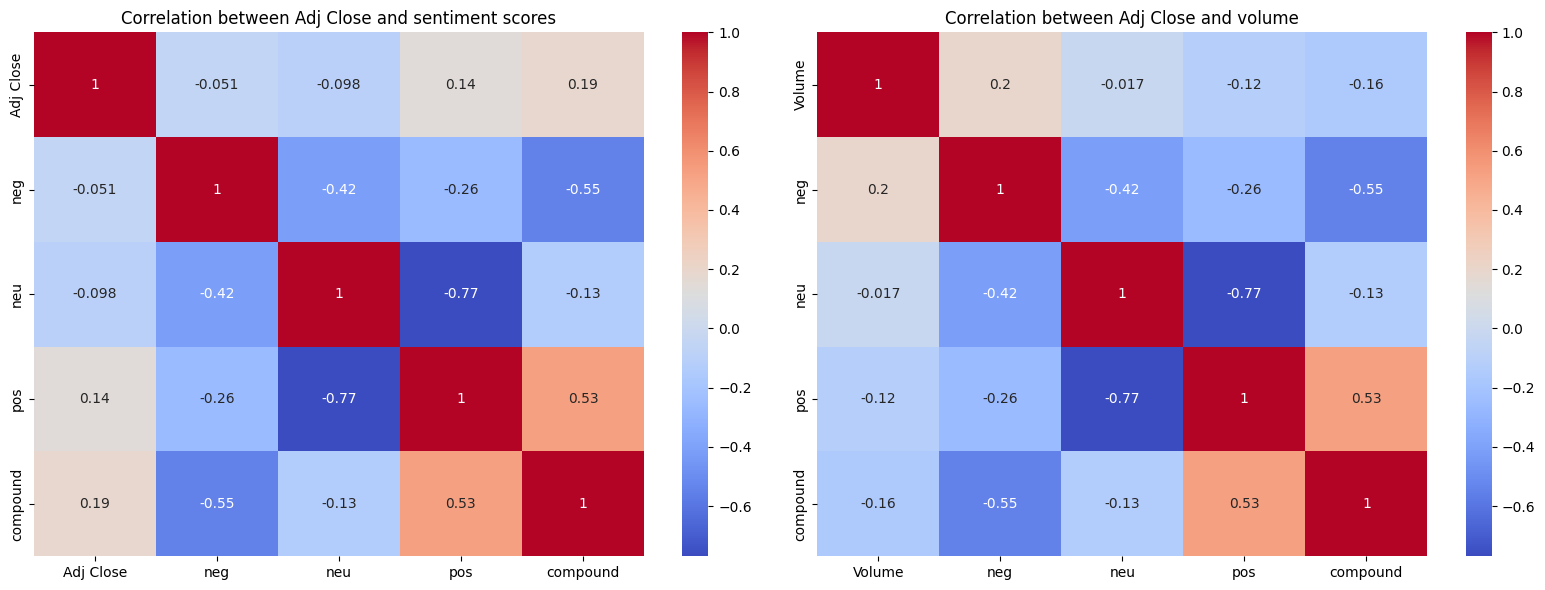

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate correlation matrices
sentiment_corr = analysis_data[['Adj Close', 'neg', 'neu', 'pos', 'compound']].corr()
volume_corr = analysis_data[['Volume', 'neg', 'neu', 'pos', 'compound']].corr()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot correlation between Adj Close and sentiment scores
sns.heatmap(sentiment_corr, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation between Adj Close and sentiment scores')

# Plot correlation between Adj Close and volume
sns.heatmap(volume_corr, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation between Adj Close and volume')

plt.tight_layout()
plt.show()

**Plotting Graphs:**

Visualization of the results is performed using matplotlib and seaborn for creating informative plots.
Heatmaps are generated to visualize correlations between sentiment scores and stock prices or trading volume.
Line plots are created to compare sentiment scores with stock prices and trading volume over time, providing insights into potential relationships between news sentiment and market activity.

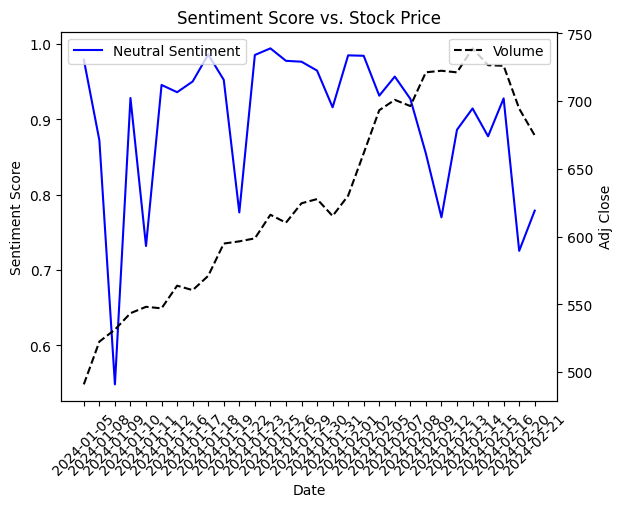

In [14]:
import matplotlib.pyplot as plt

last_10_days_df = analysis_data.tail(30)
# Create a figure and axis objects
fig, ax1 = plt.subplots()


ax1.plot(last_10_days_df['Date'], last_10_days_df['compound'], color='blue', label='Neutral Sentiment')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create a second y-axis for stock prices
ax2 = ax1.twinx()
ax2.plot(last_10_days_df['Date'], last_10_days_df['Adj Close'], color='black', linestyle='--', label='Volume')
ax2.set_ylabel('Adj Close')
ax2.legend(loc='upper right')

# Set title and show plot
plt.title('Sentiment Score vs. Stock Price')
plt.show()

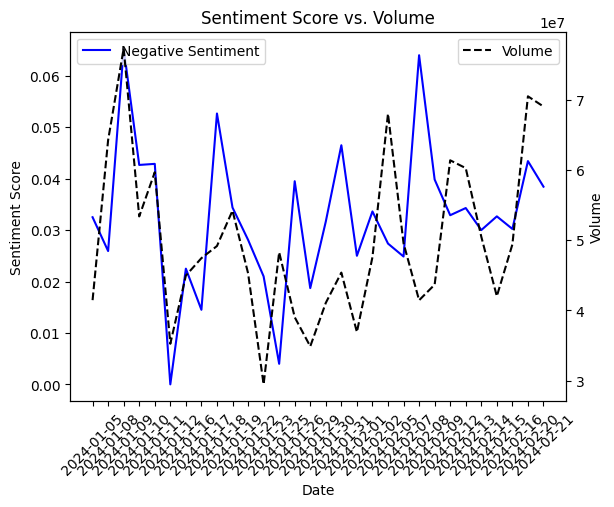

In [15]:
last_10_days_df = analysis_data.tail(30)
# Create a figure and axis objects
fig, ax1 = plt.subplots()


ax1.plot(last_10_days_df['Date'], last_10_days_df['neg'], color='blue', label='Negative Sentiment')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create a second y-axis for stock prices
ax2 = ax1.twinx()
ax2.plot(last_10_days_df['Date'], last_10_days_df['Volume'], color='black', linestyle='--', label='Volume')
ax2.set_ylabel('Volume')
ax2.legend(loc='upper right')

# Set title and show plot
plt.title('Sentiment Score vs. Volume')
plt.show()

**Important Learnings and Insights:**
Financial news sentiment significantly influences market sentiment and investor behavior, driving market dynamics and stock price movements.
Neutral sentiment in news articles exhibits a strong correlation with adjusted closing prices, indicating its importance in market predictions and trends.
Negative sentiment tends to trigger higher trading volume, reflecting intensified investor activity in response to negative news events.
Incorporating sentiment analysis into market analysis strategies enhances decision-making processes and risk management practices, offering valuable insights for investors and traders.

**Challenges:**
Scraping financial news data posed challenges due to website security measures and the dynamic nature of website structures, necessitating adaptability and persistence in data collection efforts.
Ensuring the accuracy and reliability of sentiment analysis results required meticulous preprocessing of text data and selection of appropriate sentiment analysis tools.
Interpreting correlations between news sentiment and stock market trends demanded consideration of various influencing factors and market dynamics, highlighting the complexity of market analysis.

**Future Scope:**
Exploring advanced sentiment analysis techniques, such as deep learning models, to enhance the accuracy and granularity of sentiment analysis results.
Integrating additional data sources, such as social media sentiment and company-specific metrics, to enrich the analysis and prediction of market trends.
Conducting longitudinal studies to examine the long-term impact of news sentiment on stock prices and investor sentiment, providing insights into market behavior over time.
Implementing real-time sentiment analysis capabilities to enable timely decision-making and proactive risk management in dynamic market environments.
In conclusion, this project serves as a testament to the intricate interplay between financial news sentiment, market dynamics, and investor behavior. By dissecting and analyzing news sentiment, I have gained valuable insights into the driving forces behind market movements, empowering me with knowledge and understanding to navigate the complexities of the financial markets with confidence and proficiency.